### Μέρος 2. Χρονο-Συχνοτική Ανάλυση με Συστοιχία Ζωνοπερατών Φίλτρων

***Βήμα 2.0:*** *Συστοιχία Ζωνοπερατών Φίλτρων (Filterbank)*
Σε αυτό το βήμα, σχεδιάζουμε τα φίλτρα ανάλυσης και σύνθεσης που θα χρησιμοποιήσουμε στην επεξεργασία ήχου. Ορίζουμε τις συναρτήσεις για τον υπολογισμό των συντελεστών φίλτρου με βάση δεδομένες παραμέτρους. Τα φίλτρα ανάλυσης αποσυνθέτουν ένα ηχητικό σήμα σε υποζώνες συχνοτήτων, ενώ τα φίλτρα σύνθεσης ανασυνθέτουν το σήμα από τις υποζώνες. Ο κώδικας περιλαμβάνει επίσης ένα παράδειγμα χρήσης που απεικονίζει τα φίλτρα.

Analysis Filters:
[[ 0.00423054  0.01201259  0.01882773 ... -0.0241255  -0.01392593
  -0.00444348]
 [-0.00464571 -0.01553782 -0.02797726 ...  0.01240147  0.00983922
   0.00400742]
 [-0.00377463 -0.00745285 -0.00523189 ...  0.03015213  0.01681336
   0.00483675]
 ...
 [-0.00483675  0.01681336 -0.03015213 ... -0.00523189  0.00745285
  -0.00377463]
 [ 0.00400742 -0.00983922  0.01240147 ...  0.02797726 -0.01553782
   0.00464571]
 [ 0.00444348 -0.01392593  0.0241255  ...  0.01882773 -0.01201259
   0.00423054]]
Synthesis Filters:
[[-0.00444348 -0.01392593 -0.0241255  ...  0.01882773  0.01201259
   0.00423054]
 [ 0.00400742  0.00983922  0.01240147 ... -0.02797726 -0.01553782
  -0.00464571]
 [ 0.00483675  0.01681336  0.03015213 ... -0.00523189 -0.00745285
  -0.00377463]
 ...
 [-0.00377463  0.00745285 -0.00523189 ... -0.03015213  0.01681336
  -0.00483675]
 [ 0.00464571 -0.01553782  0.02797726 ...  0.01240147 -0.00983922
   0.00400742]
 [ 0.00423054 -0.01201259  0.01882773 ...  0.0241255  -0.0139

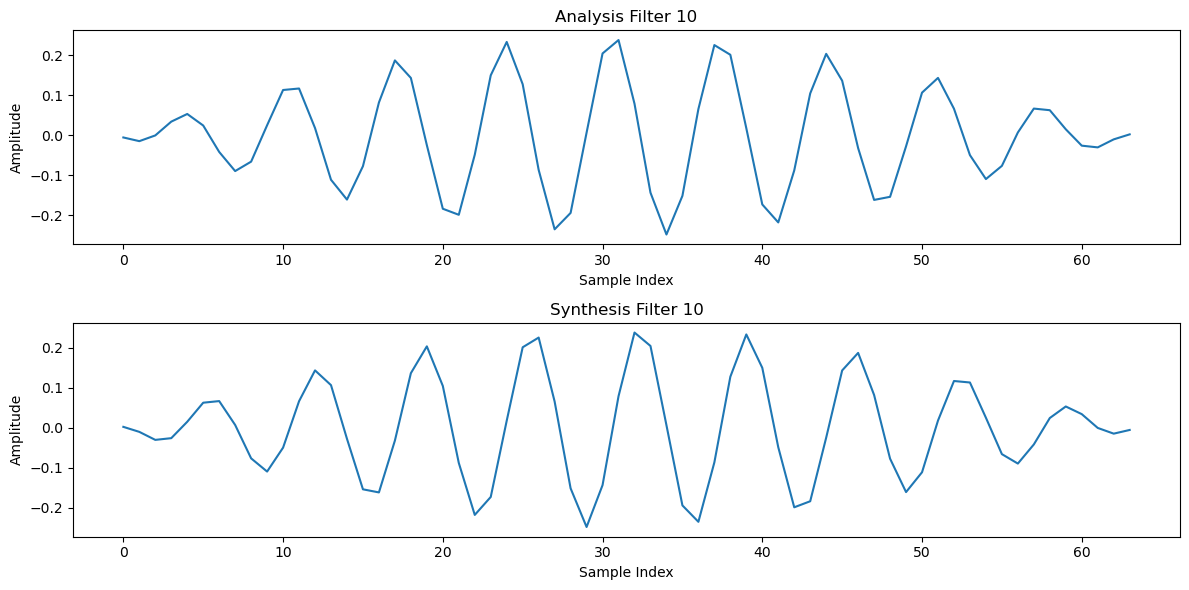

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import math
import os
import sounddevice as sd
import sys
from scipy.io.wavfile import read, write

plot = 0

def design_analysis_filters(M):
    L = 2 * M
    analysis_filters = np.zeros((M, L))
    
    for k in range(M):
        for n in range(L):
            analysis_filters[k, n] = np.sin(((n + 0.5) * np.pi / (2 * M))) * np.sqrt(2 / M) * np.cos(((2 * n + M + 1) * (2 * k + 1) * np.pi) / (4 * M))
    
    return analysis_filters

def design_synthesis_filters(analysis_filters):
    M, L = analysis_filters.shape
    synthesis_filters = np.zeros_like(analysis_filters)
    
    for k in range(M):
        for n in range(L):
            synthesis_filters[k, n] = analysis_filters[k, 2 * M - 1 - n]
    
    return synthesis_filters

# Example usage
M = 32
filter_to_plot = 10

# Design analysis filters
analysis_filters = design_analysis_filters(M)
print("Analysis Filters:")
print(analysis_filters)

# Design synthesis filters
synthesis_filters = design_synthesis_filters(analysis_filters)
print("Synthesis Filters:")
print(synthesis_filters)

# Plot the filters
plt.figure(figsize=(12, 6))

# Plot analysis filter
plt.subplot(2, 1, 1)
plt.plot(analysis_filters[filter_to_plot - 1])
plt.title(f"Analysis Filter {filter_to_plot}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

# Plot synthesis filter
plt.subplot(2, 1, 2)
plt.plot(synthesis_filters[filter_to_plot - 1])
plt.title(f"Synthesis Filter {filter_to_plot}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

***Βήμα 2.1:*** *Ανάλυση με Συστοιχία Φίλτρων*<br>
Ο κώδικας διαβάζει το αρχείο ήχου "music.wav" που μας δίνεται, αναπαράγει τον αρχικό ήχο (το κομμάτι αυτό είναι σε comment για να μην παίζει κάθε φορά που τρέχουμε το πρόγραμμα), παραθυροποιεί το σήμα, δημιουργεί φίλτρα ανάλυσης, συνενώνει το παραθυρωμένο σήμα με τα φίλτρα και τελικά σχεδιάζει το αρχικό, το παραθυροποιημένο, το φιλτραρισμένο και το αποδεκατισμένο σήμα, προκειμένου να τα συγκρίνουμε οπτικά μεταξύ τους.


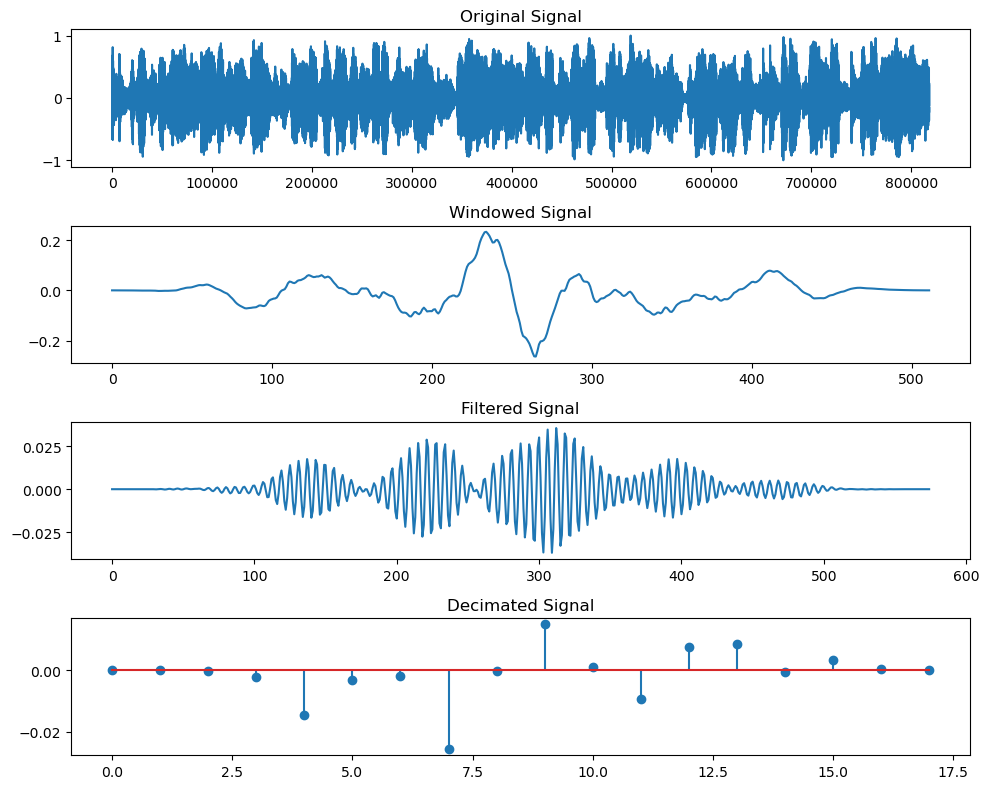

In [2]:
def window_signal(original, window, length):
    signal = []
    start = 0
    while start + length < len(original):
        temp = []
        for n in range(length):
            temp.append(original[start + n] * window[n])
        signal.append(temp)
        start += length
    return signal

def decimate(signal, factor):
    temp = []
    for i in range(len(signal)):
        if i % factor == 0:
            temp.append(signal[i])
    return temp

def convert_to_mono(wav_data):
    if wav_data.ndim == 2:
        return np.mean(wav_data, axis=1)
    return wav_data

def normalize_signal(wav_data):
    max_val = np.max(np.abs(wav_data))
    return wav_data / max_val

def read_wav_file(filename):
    sample_rate, wav_data = wavfile.read(filename)
    mono_data = convert_to_mono(wav_data)
    normalized_data = normalize_signal(mono_data)
    return sample_rate, normalized_data

# Read the audio file from the current working directory
cwd = os.getcwd()
path = os.path.join(cwd, "music.wav")
samplerate, original = read_wav_file(path) 

# Play the original sound
#sd.play(original, samplerate)
#sd.wait()

# Window the signal
N = 512
window = np.hanning(N)
#window = np.ones(N)
windowed_signal = window_signal(original, window, N)

# Generate the analysis filters
M = 32
analysis_filters = design_analysis_filters(M)

# Convolve the windowed signal with the analysis filters
filtered_signal = [[np.convolve(analysis_filters[k], np.array(windowed_signal[i]).flatten()) for k in range(M)] for i in range(len(windowed_signal))]

# Plotting
plt.figure(figsize=(10, 8))

# Original Signal
plt.subplot(4, 1, 1)
plt.title('Original Signal')
plt.plot(original)

# Windowed Signal
plt.subplot(4, 1, 2)
plt.title('Windowed Signal')
plt.plot(windowed_signal[10])

# Filtered Signal
plt.subplot(4, 1, 3)
plt.title('Filtered Signal')
plt.plot(filtered_signal[10][10])

# Decimated Signal
decimated_filtered_signal = [[decimate(filtered_signal[i][k], M) for k in range(M)] for i in range(len(windowed_signal))]

plt.subplot(4, 1, 4)
plt.title('Decimated Signal')
plt.stem(decimated_filtered_signal[10][10])

plt.tight_layout()
plt.show()

***Βήμα 2.2:*** *Κβαντοποίηση*<br>
Ο κώδικας ξεκινά με τη φόρτωση και την οπτικοποίηση του συνολικού κατωφλιού κάλυψης του ψυχοακουστικού μοντέλου που υπολογίστηκε στο Μέρος 1, «Tg». Στη συνέχεια, υπολογίζει τα εύρη συχνοτήτων και εκτελεί κβαντοποίηση στο αποδεκατισμένο φιλτραρισμένο σήμα. Ο κώδικας εφαρμόζει κβαντισμό για να μειώσει την ανάλυση πλάτους του σήματος και αποθηκεύει τα κβαντισμένα σήματα. Τα κβαντισμένα σήματα στη συνέχεια παρεμβάλλονται για να αποκατασταθούν οι χαμένες πληροφορίες, με αποτέλεσμα ένα παρεμβαλλόμενο σήμα. Τέλος, το παρεμβαλλόμενο σήμα σχεδιάζεται για οπτικοποίηση. Αυτός ο κώδικας επιτρέπει την ανάλυση και την επεξεργασία των ηχητικών σημάτων χρησιμοποιώντας τεχνικές όπως το παράθυρο, το φιλτράρισμα, η κβαντοποίηση και η παρεμβολή.

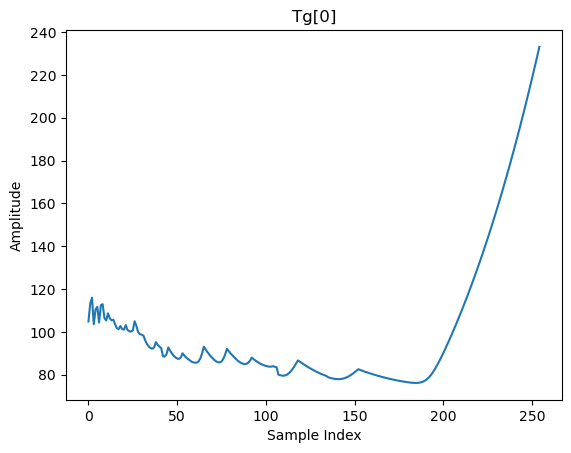

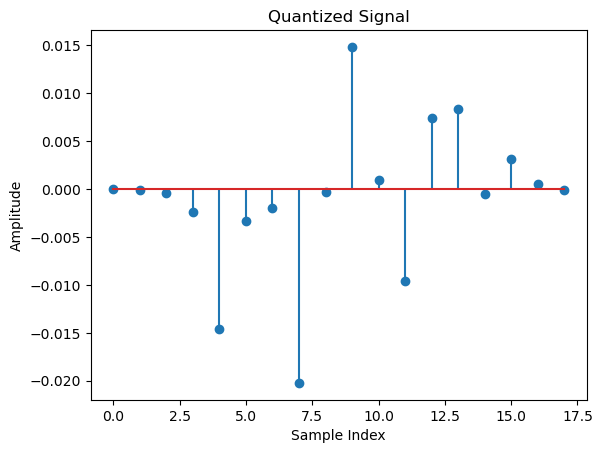

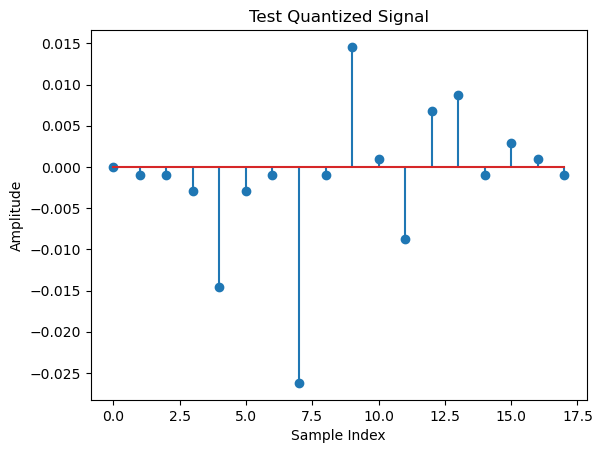

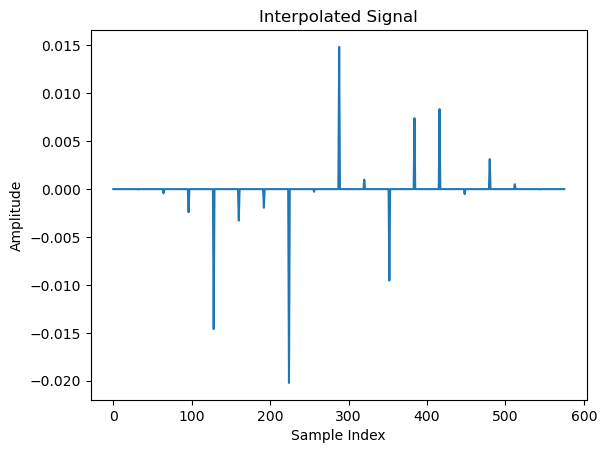

In [3]:
# Load Tg signal from part 1
Tg = np.load("T_g_i.npy")

# Plot the Tg[0] signal
plot += 1
plt.figure(plot)
plt.title("Tg[0]")
plt.plot(Tg[0])
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

# Define parameters
L = 2 * M
R = 2 ** 16

# Function to calculate frequency ranges
def f(k):
    return ((2 * k - 1) * samplerate * math.pi / (L) - samplerate * math.pi / (L),
            (2 * k - 1) * samplerate * math.pi / (L) + samplerate * math.pi / (L))


# Function to calculate new Tg values based on frequency range
def newTg(k, T_g):
    f_ = f(k)
    temp = []
    for i in range(len(T_g)):
        f_i = samplerate * 2 * math.pi * i / N
        if f_[0] <= f_i <= f_[1]:
            temp.append(T_g[i])
    return R / min(temp)


# Calculate Bk values for each windowed signal
Bk = [[math.ceil(np.log2(newTg(k, Tg[i])) - 1) for k in range(1, M + 1)] for i in range(len(windowed_signal))]

delta = []

# Calculate delta values for each decimated signal
for i in range(len(decimated_filtered_signal)):
    temp = []
    for k in range(M):
        range_ = max(decimated_filtered_signal[i][k]) - min(decimated_filtered_signal[i][k])
        temp.append(range_ / (math.pow(2, Bk[i][k])))
    delta.append(temp)


# Function for quantization
def quantization(x, Delta_s, b):
    newSig = []
    for i in range(len(x)):
        bool = 0
        for k in range(2 ** (b - 1)):
            if k * Delta_s <= abs(x[i]) <= (k + 1) * Delta_s:
                if x[i] > 0:
                    newSig.append((0.5 + k) * Delta_s)
                elif x[i] < 0:
                    newSig.append((-0.5 - k) * Delta_s)
                else:
                    newSig.append(0.0)
                bool = 1
                break
        if bool == 0:
            if x[i] >= 0:
                newSig.append((2 ** (b - 1) - 0.5) * Delta_s)
            else:
                newSig.append(-(2 ** (b - 1) - 0.5) * Delta_s)
    return newSig


# Quantize the decimated filtered signal
quantized_signal = [[quantization(decimated_filtered_signal[i][k], delta[i][k], Bk[i][k])
                     for k in range(len(decimated_filtered_signal[i]))]
                    for i in range(len(decimated_filtered_signal))]

# Plot the quantized signal
plot += 1
plt.figure(plot)
plt.title('Quantized Signal')
plt.stem(quantized_signal[10][10])
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')


test_Bk = 8
original = list(original)


# Function to calculate the maximum value of a segment
def max_of_seg(seg):
    maxx = 0
    for k in seg:
        if maxx < max(k):
            maxx = max(k)
    return maxx


# Function to calculate the minimum value of a segment
def min_of_seg(seg):
    minn = 0
    for k in seg:
        if minn > min(k):
            minn = min(k)
    return minn


# Test quantization with a specific Bk value
test_quantized = []
for i in range(len(decimated_filtered_signal)):
    temp = []
    test_delta = (np.max(windowed_signal[i]) - np.min(windowed_signal[i])) / (2 ** test_Bk)
    for k in range(len(decimated_filtered_signal[i])):
        temp.append(quantization(decimated_filtered_signal[i][k], test_delta, test_Bk))

    test_quantized.append(temp)
    
    
# Plot the test quantized signal
plot += 1
plt.figure(plot)
plt.title("Test Quantized Signal")
plt.stem(test_quantized[10][10])
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')


interpolated = []
for q in quantized_signal:
    temp2 = []
    for k in q:
        temp = []
        for l in k:
            temp.append(l)
            for m in range(M - 1):
                temp.append(0)
        temp2.append(temp)
    interpolated.append(temp2)


# Plot the interpolated signal
plot += 1
plt.figure(plot)
plt.title("Interpolated Signal")
plt.plot(interpolated[10][10])
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.show()


***Βήμα 2.3:*** *Σύνθεση*<br>
Ο κώδικας εκτελεί διάφορες λειτουργίες σε σήματα ήχου για συμπίεση και ανακατασκευή. Ξεκινά με την οπτικοποίηση του αρχικού σήματος και τον υπολογισμό των περιοχών συχνοτήτων. Στη συνέχεια, το σήμα κβαντοποιείται χρησιμοποιώντας έναν καθορισμένο αριθμό δυαδικών ψηφίων, με αποτέλεσμα κβαντισμένα σήματα. Η παρεμβολή εφαρμόζεται στα κβαντισμένα σήματα για την αποκατάσταση των χαμένων πληροφοριών. Τα παρεμβαλλόμενα σήματα φιλτράρονται χρησιμοποιώντας φίλτρα σύνθεσης και τα προκύπτοντα φιλτραρισμένα σήματα αθροίζονται. Η τεχνική επικάλυψης και προσθήκης χρησιμοποιείται για την ανακατασκευή σήματος. Το ανακατασκευασμένο σήμα οπτικοποιείται και συγκρίνεται με το αρχικό σήμα. Το ανακατασκευασμένο σήμα αποθηκεύεται ως αρχείο εξόδου. Περαιτέρω ανάλυση περιλαμβάνει τη μετατόπιση των σημάτων και τον υπολογισμό του μέσου τετραγώνου σφάλματος (MSE) μεταξύ του ανακατασκευασμένου σήματος και του αρχικού σήματος. Το MSE και ο λόγος συμπίεσης υπολογίζονται και εμφανίζονται. Τέλος, παρουσιάζονται διάφορα διαγράμματα για την οπτικοποίηση των συμπιεσμένων και ανακατασκευασμένων σημάτων, του σφάλματος και των αποτελεσμάτων συμπίεσης.

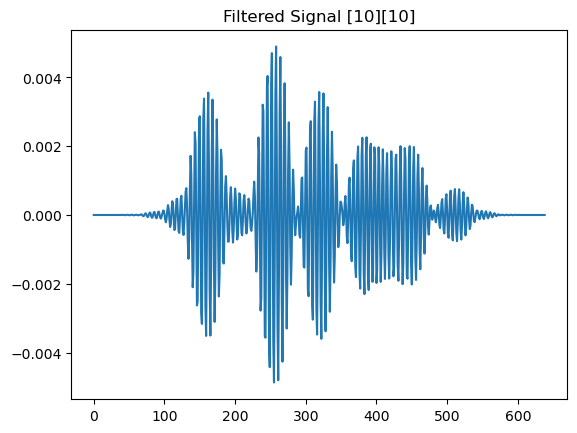

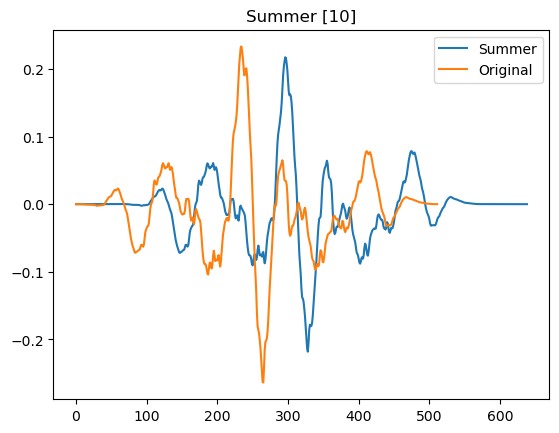

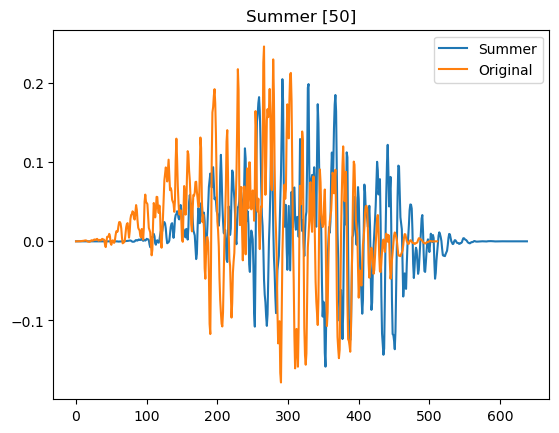

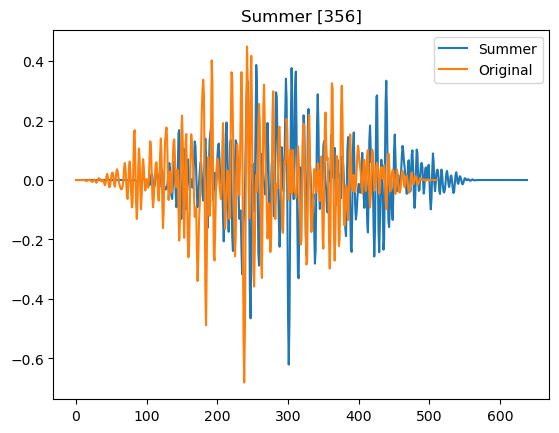

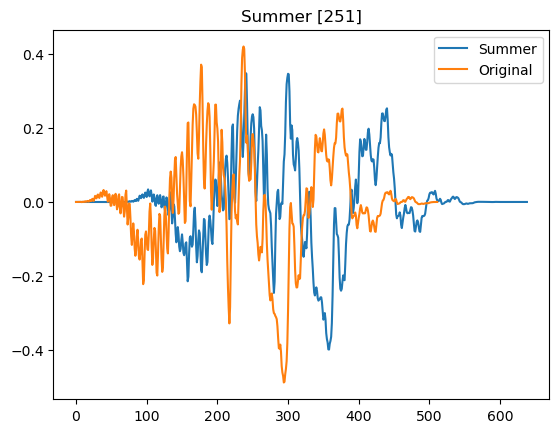

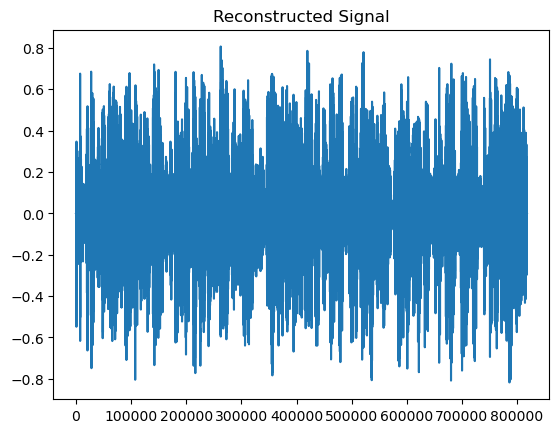

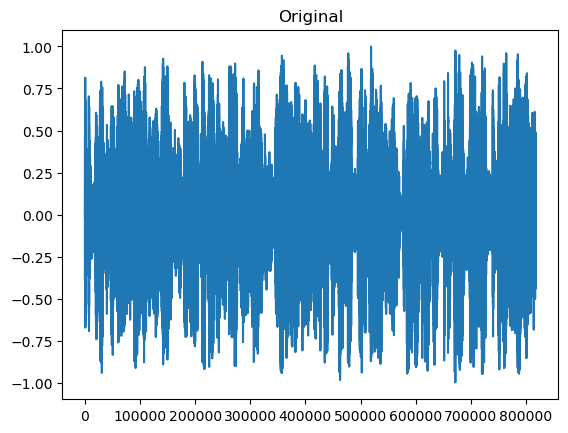

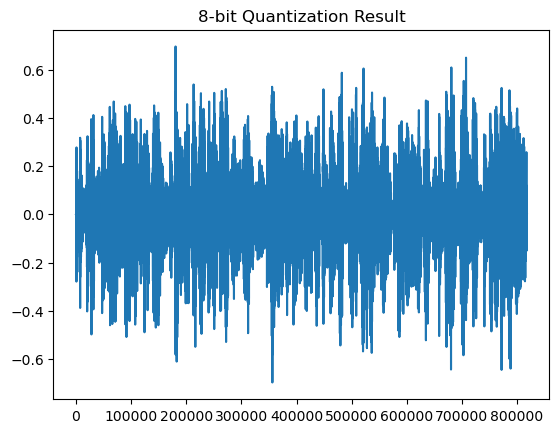

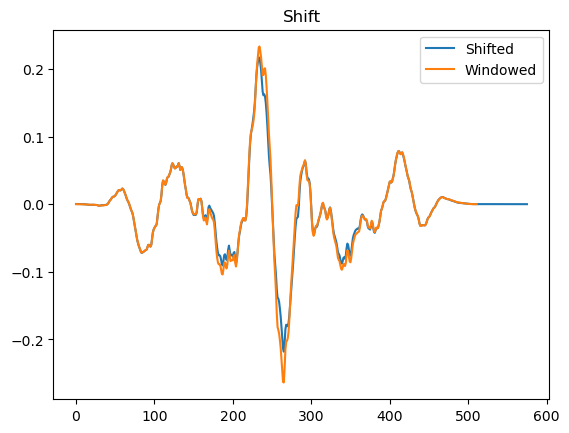

MSE is 0.01870306604927925
Test MSE is 0.026787202717439118
Initial number of bits: 13086208
Compressed number of bits: 8181504
Compression (%): 37.47994835478696


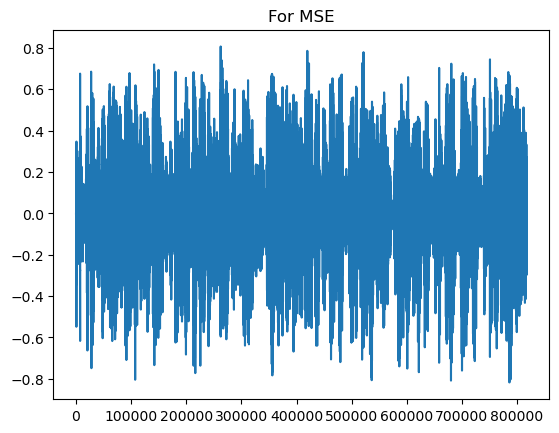

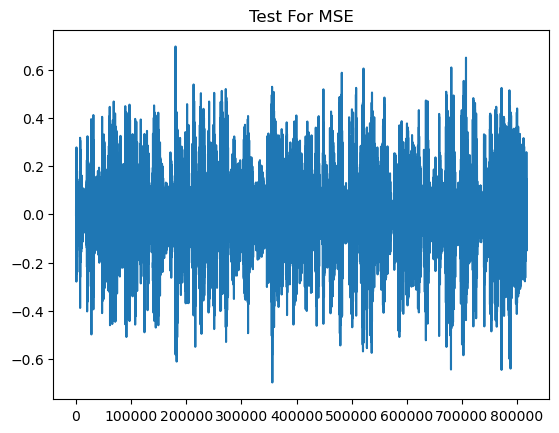

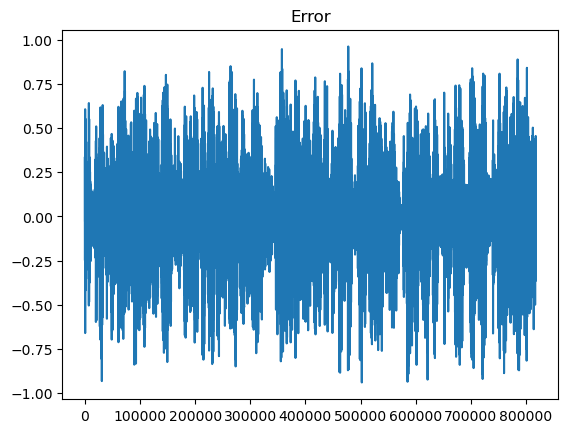

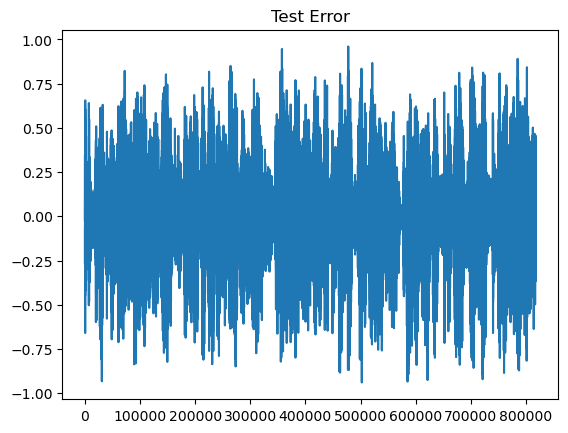

In [4]:
#Filtering
# Apply convolution between interpolated signals and synthesis filters
last_filtered_signal = [[np.convolve(interpolated[i][k], synthesis_filters[k]) for k in range(len(interpolated[i]))]
                        for i in range(len(interpolated))]

plot += 1
plt.figure(plot)
plt.title("Filtered Signal [10][10]")
plt.plot(last_filtered_signal[10][10])


#Summation
# Sum the filtered signals to obtain the summer signals
summer = []

for l in last_filtered_signal:
    temp = []
    for k in l:
        for n, c in enumerate(k):
            if n >= len(temp):
                temp.append(0)  # Add elements to the list if the index is out of bounds
            temp[n] += c
    summer.append(temp)
    

#Plotting
# Generate plots to compare the summer signals with the original windowed signals

plot += 1
plt.figure(plot)
plt.title("Summer [10]")
plt.plot(summer[10], label="Summer")
plt.plot(windowed_signal[10], label="Original")  
plt.legend()

plot += 1
plt.figure(plot)
plt.title("Summer [50]")
plt.plot(summer[50], label="Summer")
plt.plot(windowed_signal[50], label="Original")  
plt.legend()

plot += 1
plt.figure(plot)
plt.title("Summer [356]")
plt.plot(summer[356], label="Summer")
plt.plot(windowed_signal[356], label="Original")  
plt.legend()

plot += 1
plt.figure(plot)
plt.title("Summer [251]")
plt.plot(summer[251], label="Summer")
plt.plot(windowed_signal[251], label="Original")  
plt.legend()


#Overlap and Add Reconstruction
# Reconstruct the signal by overlapping and adding the summer signals

def overlap(my_list, length, tot_length, seg_length):
    start = 0
    temp = np.zeros(tot_length)

    for l in my_list:
        if start >= tot_length - seg_length:
            return temp
        for i in range(length):
            if start + i >= tot_length:
                break
            temp[start + i] += l[i]

        start += seg_length
    return temp


# Apply overlap and add reconstruction to obtain the reconstructed signal
sum_overlap_add = overlap(summer, len(summer[0]), len(original), N)

plot += 1
plt.figure(plot)
plt.title("Reconstructed Signal")
plt.plot(sum_overlap_add)

plot += 1
plt.figure(plot)
plt.title("Original")
plt.plot(original)

# Save the Reconstructed Signal
# Convert the reconstructed signal to a float32 array and save it as an audio file

sum_overlap_add = np.array(sum_overlap_add, dtype=np.float32)
write("output.wav", samplerate, np.array(sum_overlap_add, dtype=np.float32))


# Play the reconstructed signal
#sd.play(sum_overlap_add, samplerate)
#sd.wait()


# Apply the same process to test signals (for 8-bit quantization)
# Generate interpolated signals for test quantized signals

test_interpolated = []
for q in test_quantized:
    temp2 = []
    for k in q:
        temp = []
        for l in k:
            temp.append(l)
            for m in range(M - 1):
                temp.append(0)

        temp2.append(temp)

    test_interpolated.append(temp2)

    
# Filter the test interpolated signals
test_last_filtered_signal = [[np.convolve(test_interpolated[i][k], synthesis_filters[k]) for k in range(len(test_interpolated[i]))] for i in range(len(interpolated))]


test_summer = []


# Sum the filtered signals for test signals

for l in test_last_filtered_signal:
    temp = np.zeros(639)
    for k in l:
        for n, c in enumerate(k):
            temp[n] += c

    test_summer.append(list(temp))

    
# Reconstruct the test signal using overlap and add

test_sum_overlap_add = overlap(test_summer, len(test_summer[0]), len(original), N)

test_sum_overlap_add = np.array(test_sum_overlap_add, dtype=np.float32)
write("output_8bit.wav", samplerate, np.array(test_sum_overlap_add, dtype=np.float32))


# Play the test reconstructed signal
#sd.play(test_sum_overlap_add, samplerate)
#sd.wait()

plot += 1
plt.figure(plot)
plt.title("8-bit Quantization Result")
plt.plot(test_sum_overlap_add)

plt.show()


# Signal Shifting
# Shift the summer signals for comparison with windowed signals
def shifting(signal, factor):
    return signal[factor:]

def calculate_factor(signal, recon):
    return recon.index(max(recon)) - signal.index(max(signal))

sum_overlap_add = list(sum_overlap_add)
windowed_signal = list(windowed_signal)

shifted = [shifting(summer[i], 63) for i in range(len(summer))]
test_shifted = [shifting(test_summer[i], 63) for i in range(len(test_summer))]

plot += 1
plt.figure(plot)
plt.title("Shift")
plt.plot(shifted[10], label="Shifted")
plt.plot(windowed_signal[10], label="Windowed")
plt.legend()

plt.show()


#Calculate Error and MSE
# Calculate the error between the original signal and the shifted summer signals

for_MSE = overlap(shifted, len(shifted[0]), len(original), N)
test_for_MSE = overlap(test_shifted, len(test_shifted[0]), len(original), N)

plot += 1
plt.figure(plot)
plt.title("For MSE")
plt.plot(for_MSE)

plot += 1
plt.figure(plot)
plt.title("Test For MSE")
plt.plot(test_for_MSE)

# Calculate the Mean Squared Error (MSE) between the original signal and the shifted summer signals

def MSE(signal, recon):
    return np.mean(np.array([(signal[i] - recon[i])**2 for i in range(min(len(signal), len(recon)))]))

def calculate_error(signal, recon):
    return [signal[i] - recon[i] for i in range(min(len(signal), len(recon)))]

error = calculate_error(original, for_MSE)
test_error = calculate_error(original, test_for_MSE)

plot += 1
plt.figure(plot)
plt.title("Error")
plt.plot(error)

plot += 1
plt.figure(plot)
plt.title("Test Error")
plt.plot(test_error)

print("MSE is", MSE(original, for_MSE))
print("Test MSE is", MSE(original, test_for_MSE))

# Compression Analysis
# Calculate the initial number of bits and the compressed number of bits

initial_number_of_bits = 16 * len(original)

compress_bits = 0
for i in range(len(Bk)):
    for k in range(M):
        compress_bits += Bk[i][k] * 18

print("Initial number of bits:", initial_number_of_bits)
print("Compressed number of bits:", compress_bits)
print("Compression (%):", ((initial_number_of_bits - compress_bits) / initial_number_of_bits) * 100)

plt.show()